# Pricing test data challenge

#### *Darren Tanner*

### Goals
The goal of this data analysis is to asses the following:
1. Whether the price increase associated with a test group in an A/B test leads to higher revenue
2. Whether the price increase has different effects/outcomes in different user segments

### Findings
* The increased price (\$59) for the test group led to a lower conversion rate (0.016\%) compared to the control group given our standard price (0.020\%)
* This decrease in conversion rate was offset by increased average revenue per user in the test group (increase of \$0.14 revenue per user)
* The revenue per user was highest in the test group for users on mobile devices, followed by web users in the test group. Platform made no difference for users in the control group

## Recommendations
1. Increasing the price to $59 can lead to higher revenue. Lower conversion rates are offset by higher margins and revenue per user. However, this may lead over time to a decrease in users. This trade-off needs to be addressed with marketing efforts to help offset customer losses.
2. If the price increase is implemented, marketing efforts should heavily web users in order offset the loss in conversions.
3. Additional analyses should also investigate conversion rate as a function of time, as well as source of users. A downtrend in conversions over time witht he higher price could nullify the recommendation to implement the price increase.

In [6]:
## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')
from altair.expr import datum, if_
import pandas_profiling
from scipy.stats import chi2_contingency as chi2

In [2]:
data = pd.read_csv('test_results.csv', parse_dates=[1])
users = pd.read_csv('user_table.csv')

### Calculate conversion rates and Revenue Per User (RPU) in the control and test groups

In [3]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
# Check that price and test group line up
pd.crosstab(index=data['price'], columns=data['test'])

test,0,1
price,,
39,202517,155
59,210,113918


In [11]:
# These are errors.  Throw out these observations.
data = data[((data['test'] == 0) & (data['price'] == 39)) | ((data['test'] == 1) & (data['price'] == 59))]

In [12]:
# Some preliminary data exploration
num_no_test = data.groupby('test').count().user_id.iloc[0]
num_test = data.groupby('test').count().user_id.iloc[1]
grouped_data = data.groupby(['test', 'converted']).count().user_id.reset_index()
grouped_data.columns = ['Test', 'Converted', 'Count']
grouped_data.loc[grouped_data['Test'] == 0, 'Percent Conversion'] = grouped_data.Count/num_no_test
grouped_data.loc[grouped_data['Test'] == 1, 'Percent Conversion'] = grouped_data.Count/num_test

In [13]:
grouped_data

,Test,Converted,Count,Percent Conversion
0,0,0,198487,0.980100
1,0,1,4030,0.019900
2,1,0,112146,0.984445
3,1,1,1772,0.015555


In [14]:
# Chi squre test for ratio of conversions
conversion_table = pd.crosstab(index=data['test'], columns=data['converted'])
c2, p, dof, __ = chi2(conversion_table)
print(c2, p, dof)

76.21203591082431 2.5478408500937737e-18 1


A somewhat higher proportion of users in the control group converted. The proportion of conversions is statistically significant between the two groups (*p* < .001). But this does not mean that this was bad for revenue. Let's look at revenue per user in each group to get an idea of whether the higher price in the test group led to increased revenue.

In [15]:
grouped_data['Total Revenue'] = ''
grouped_data.loc[grouped_data['Test'] == 0, 'Total Revenue'] = grouped_data[grouped_data.Test == 0].Count*39
grouped_data.loc[grouped_data['Test'] == 1, 'Total Revenue'] = grouped_data[grouped_data.Test == 1].Count*59
grouped_data['Avg. Revenue per User'] = ''
grouped_data.loc[grouped_data['Test'] == 0, 'Avg. Revenue per User'] = grouped_data[grouped_data.Test == 0]['Total Revenue']/num_no_test
grouped_data.loc[grouped_data['Test'] == 1, 'Avg. Revenue per User'] = grouped_data[grouped_data.Test == 1]['Total Revenue']/num_test

In [16]:
grouped_data

,Test,Converted,Count,Percent Conversion,Total Revenue,Avg. Revenue per User
0,0,0,198487,0.980100,7740993,38.2239
1,0,1,4030,0.019900,157170,0.776083
2,1,0,112146,0.984445,6616614,58.0823
3,1,1,1772,0.015555,104548,0.917748


**Here we can see that, even though a smaller proportion of users converted in the test ($59) group, the higher price offset this. There was higher average revenue per user in that group test group, who had the higher price. Total revenue in the test group was smaller, but this can be accoutned for by the lower number of users in the test group. This indicates that the higher price of the product license could increase overall revenue. However, below I investigate whether this increase is statistically significant by bootstrapping 95% confidence intervals of Revenue per User (RPU) for the control and test groups.**

In [17]:
# Bootstrap CIs for RPU in the two groups

# Initialize same variables
n_samp = 10000
control_samples = []
test_samples = []
control_data = data[data['test'] == 0]
test_data = data[data['test'] == 1]

# Bootstrap control cases
for i in range(n_samp):
    curr_samp = control_data.sample(n=control_data.shape[0], replace=True)
    RPU = (sum(curr_samp.converted)*39)/curr_samp.shape[0]
    control_samples.append(RPU)

# Bootstrap test cases
for i in range(n_samp):
    curr_samp = test_data.sample(n=test_data.shape[0], replace=True)
    RPU = (sum(curr_samp.converted)*59)/curr_samp.shape[0]
    test_samples.append(RPU)
    


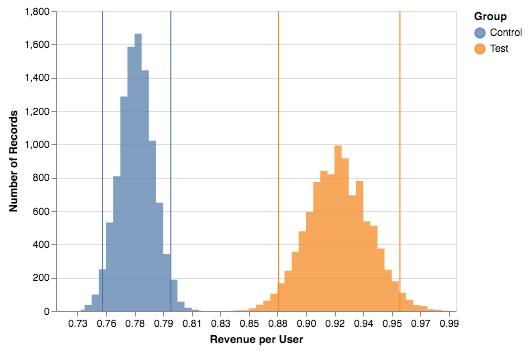

In [18]:
# Plot histograms of the bootstrap samples
control_boots = pd.DataFrame({'RPU': control_samples, 'Group': 'Control'})
test_boots = pd.DataFrame({'RPU': test_samples, 'Group': 'Test'})
bootstraps = pd.concat([control_boots, test_boots])

# Get bounds for 95% CIs
control_CI = control_boots.quantile([.025, .975])
test_CI = test_boots.quantile([.025, .975])
CI_df = pd.concat([control_CI, test_CI])
CI_df['Group'] = ['Control','Control', 'Test', 'Test']

hist = alt.Chart(bootstraps).mark_area(
    opacity=0.7,
    interpolate='step'
).encode(
    alt.X('RPU', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    color='Group'
)

bounds = alt.Chart(CI_df).mark_rule().encode(
    x=alt.X('RPU:Q', axis=alt.Axis(title='Revenue per User')),
    color='Group'
)

hist + bounds

**The plot above shows the distribution of bootstrap samples, along with the bounds of the 95% confidence intervals for each the control and test groups. As is apparent, the confidence intervals for the two groups do not overlap: the difference in average revenue per user is statistically significant.  The price increase in the test group led to significantly higher revenu per user.**

### Identify differential effects of price increase by user segment

In [19]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [20]:
# Conversion and RPU by device
devices = data.groupby(['test', 'converted', 'device']).count().user_id.reset_index()
users_per_group_device = data.groupby(['test','device']).count().user_id
devices.columns = ['Test', 'Converted', 'Device', 'Count']
devices['Total Revenue'] = ''
devices.loc[devices['Test'] == 0, 'Total Revenue'] = devices.Count.apply(lambda x: x*39)
devices.loc[devices['Test'] == 1, 'Total Revenue'] = devices.Count.apply(lambda x: x*59)
devices['Revenue Per User'] = ''
devices.loc[(devices['Test'] == 0) & (devices['Device'] == 'mobile'), 'Revenue Per User'] = devices['Total Revenue']/users_per_group_device[0][0]
devices.loc[(devices['Test'] == 0) & (devices['Device'] == 'web'), 'Revenue Per User'] = devices['Total Revenue']/users_per_group_device[0][1]
devices.loc[(devices['Test'] == 1) & (devices['Device'] == 'mobile'), 'Revenue Per User'] = devices['Total Revenue']/users_per_group_device[1][0]
devices.loc[(devices['Test'] == 1) & (devices['Device'] == 'web'), 'Revenue Per User'] = devices['Total Revenue']/users_per_group_device[1][1]
devices = devices[devices.Converted == 1]
devices['Group'] = np.where(devices.Test == 0, 'Control', 'Test')
devices.head(10)

,Test,Converted,Device,Count,Total Revenue,Revenue Per User,Group
2,0,1,mobile,2392,93288,0.775017,Control
3,0,1,web,1638,63882,0.777645,Control
6,1,1,mobile,1064,62776,0.952624,Test
7,1,1,web,708,41772,0.869888,Test


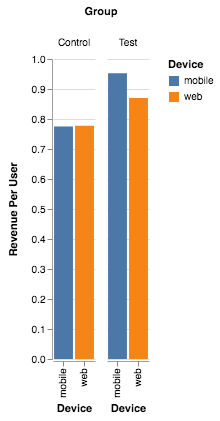

In [22]:
alt.Chart(devices).mark_bar(stroke='transparent').encode(
    x=alt.X('Device:N', stack=None),
    y='Revenue Per User',
    color='Device:N',
    column='Group'
).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
)

This plot shows us an interaction between device type and RPU: The test price of \$59 showed increases in RPU for both mobile and web devices, but the increase was more pronounced for web devices. If the price increase is implemented, marketing efforts should target mobile platforms.

In [203]:
users_per_group_device[1][0]

65990